In [1]:
# Imports
import numpy as np
import pandas as pd

import math


import re
import string


from google.cloud import bigquery



In [2]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

client = bigquery.Client(location="US", project="helio-staging")

Client creating using default project: helio-staging


In [3]:
NORMALIZED_URL_LI = ['beyondmeat.com', 
                     'impossiblefoods.com', 
                     'gardein.com', 
                     'amys.com', 
                     'morningstarfarms.com',
                    'lightlife.com',
                    'daring.com',
                    'drpraegers.com',
                    'eatalphafoods.com',
                    'sweetearthfoods.com']

BRAND_NAME_LI = ['Beyond Meat',
                 'Impossible Foods',
                 'Gardein',
                 'Amys',
                 'Morninstar Farms',
                 'Light Life',
                 'Daring',
                 'Dr. Praegers',
                 'Alpha Foods',
                 'Sweet Earth',
]



brand_name_di = dict(zip(NORMALIZED_URL_LI, BRAND_NAME_LI))


# Review count

In [4]:
job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI)
        ]
)
max_date_query = """
    SELECT max(execution_date)
    FROM `helio-staging.online_reviews.online_reviews__deduped_review__1_0`
    where execution_date > DATE_ADD(current_date(), INTERVAL -10 DAY)
    and normalized_url IS NOT NULL
    """
query_job = client.query(
    max_date_query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query

max_date = query_job.to_dataframe()['f0_'].astype('str')[0]


In [12]:
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI),
        bigquery.ScalarQueryParameter("max_date", "STRING", max_date)
    ]
)
review_query = """
    SELECT
    normalized_url,
    review_date,
    source_name,
    review_content
    FROM `helio-staging.online_reviews.online_reviews__deduped_review__1_0`
    WHERE normalized_url IN UNNEST (@url)
    AND execution_date = @max_date
    """
query_job = client.query(
    review_query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query

reviews = query_job.to_dataframe()
reviews = reviews.loc[reviews.astype(str).drop_duplicates().index]
reviews["date"] = pd.to_datetime(reviews["review_date"])
reviews["month_year"] = reviews["date"].dt.strftime('%Y-%m')
reviews["Brand"] = reviews["normalized_url"].map(brand_name_di)
reviews = reviews[reviews["date"]>='2012-1-1']

In [13]:
reviews_pivot = reviews.pivot_table(values = "review_content", index = "month_year", columns = "Brand", aggfunc = "count", fill_value=0)
reviews_pivot_cum = reviews_pivot.cumsum()

<AxesSubplot:title={'center':'Review Counts by Brand'}>

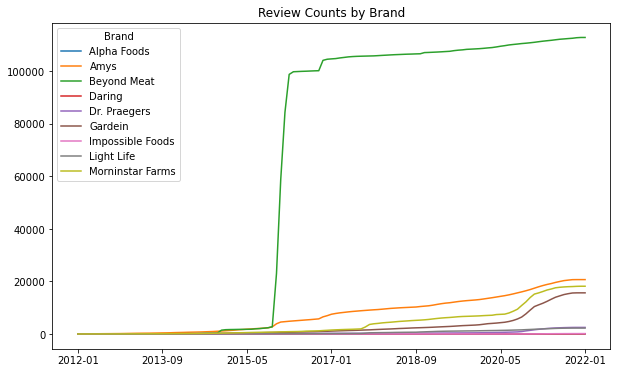

In [133]:
reviews_pivot_cum.plot(figsize = (10,6),xlabel="", title= "Review Counts by Brand")

In [15]:
#reviews_pivot_cum.to_excel("plant_based_meat_reviews_pvt.xlsx")
reviews_bm=reviews[reviews["normalized_url"]=="beyondmeat.com"]
reviews_bm_pivot = reviews_bm.pivot_table(values = "review_content", index = "month_year", columns = "source_name", aggfunc = "count", fill_value=0)
reviews_bm_pivot_cum = reviews_bm_pivot.cumsum()

<AxesSubplot:title={'center':'Review Counts by Brand, Normalized'}>

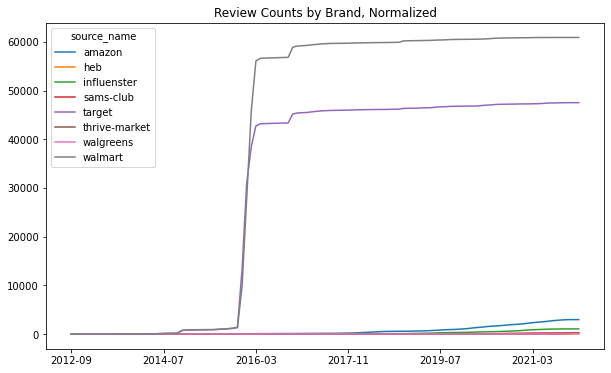

In [135]:
reviews_bm_pivot_cum.plot(figsize=(10,6),xlabel="", title= "Review Counts by Brand, Normalized")

<AxesSubplot:title={'center':'Review Counts by Brand, Normalized'}>

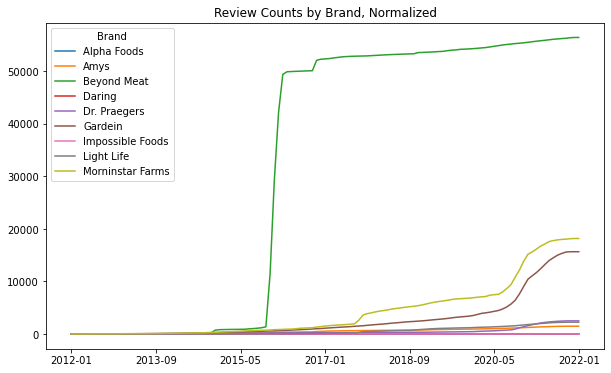

In [136]:
reviews_pivot_cum_norm = reviews_pivot_cum.copy()

for i in reviews_pivot_cum_norm:
    minimum = reviews_pivot_cum_norm[reviews_pivot_cum_norm[i]>0][i].min()
    
    reviews_pivot_cum_norm[i] = reviews_pivot_cum_norm[i]/minimum

reviews_pivot_cum_norm.plot(figsize=(10,6),xlabel="", title= "Review Counts by Brand, Normalized")

# Web traffic

In [107]:
max_date

'2021-12'

In [108]:
#alexa traffic history
max_date ='2021-12'


job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI),
        bigquery.ScalarQueryParameter("max_date", "STRING", max_date)
    ]
)
review_query = """
    SELECT
    normalized_url,
    y_m,
    avg_reach_per_million,
    FROM `helio-staging.web_traffic.alexa__traffic_history__ts__2_0` 
    WHERE normalized_url IN UNNEST (@url)
    AND execution_period = @max_date
    """
query_job = client.query(
    review_query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query

alexa = query_job.to_dataframe()
alexa = alexa.loc[alexa.astype(str).drop_duplicates().index]
alexa["Date"] = pd.to_datetime(alexa["y_m"])
alexa["Brand"] = alexa["normalized_url"].map(brand_name_di)

In [109]:
alexa_pivot = alexa.pivot_table(index = "Date", columns = "Brand", values = "avg_reach_per_million", fill_value=0)
alexa_pivot = alexa_pivot[alexa_pivot["Beyond Meat"]!=0]

<AxesSubplot:title={'center':'Alexa Average Reach Per Million'}>

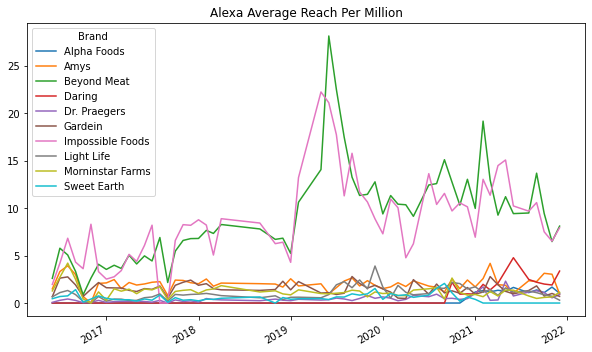

In [137]:
alexa_pivot.plot(figsize = (10,6), xlabel="", title= "Alexa Average Reach Per Million")

<AxesSubplot:xlabel='Date'>

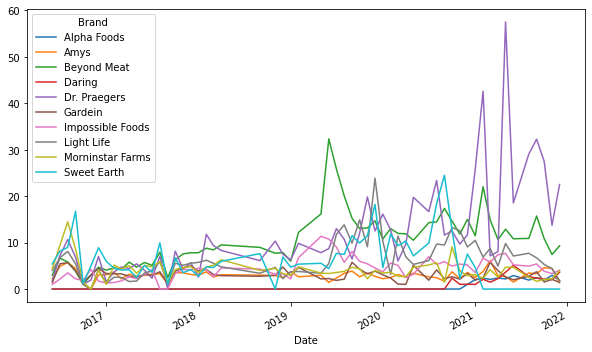

In [123]:
alexa_pivot_norm = alexa_pivot.copy()

for i in alexa_pivot_norm:
    minimum = alexa_pivot_norm[alexa_pivot_norm[i]>0][i].min()
    
    alexa_pivot_norm[i] = alexa_pivot_norm[i]/minimum

alexa_pivot_norm.plot(figsize=(10,6))

In [111]:
alexa_pivot.to_excel("plant_based_meat_alexa.xlsx")

In [114]:
#sem rush traffic history
max_date ='2021-12'
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI),
        bigquery.ScalarQueryParameter("max_date", "STRING", max_date)
    ]
)
review_query = """
    SELECT normalized_url, y_m, fct_organic_traffic,fct_adwords_traffic
    FROM `helio-staging.web_traffic.semrush__ts_interpolated__2_0`
    WHERE normalized_url IN UNNEST (@url)
    AND execution_period = @max_date
    """
query_job = client.query(
    review_query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query

sem_rush = query_job.to_dataframe()
sem_rush = sem_rush.loc[sem_rush.astype(str).drop_duplicates().index]
sem_rush = sem_rush.fillna(0)
sem_rush["total_traffic"] = sem_rush["fct_organic_traffic"]+sem_rush["fct_adwords_traffic"]
sem_rush["Brand"] = sem_rush["normalized_url"].map(brand_name_di)


In [115]:
sem_rush_pivot = sem_rush.pivot_table(index = "y_m", columns = "Brand", values = "total_traffic", fill_value=0)

In [116]:
sem_rush_pivot = sem_rush_pivot[sem_rush_pivot["Beyond Meat"]!=0]

<AxesSubplot:title={'center':'SEMrush Traffic by Brand'}>

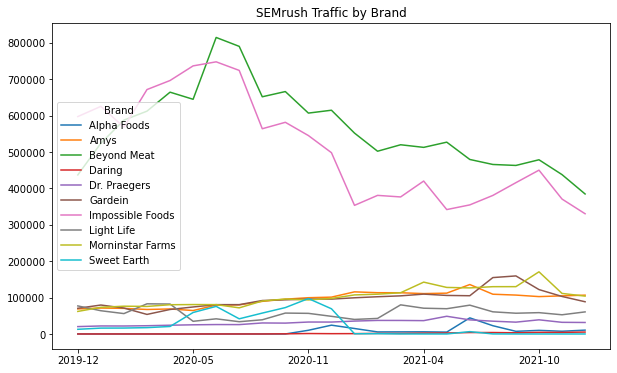

In [138]:
sem_rush_pivot.plot(figsize=(10,6),xlabel="", title= "SEMrush Traffic by Brand")

<AxesSubplot:xlabel='y_m'>

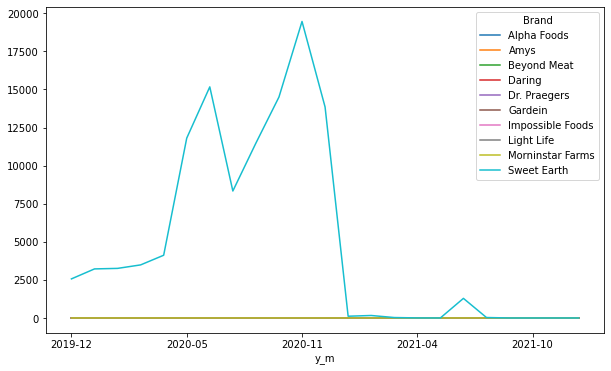

In [125]:
sem_rush_pivot_norm = sem_rush_pivot.copy()

for i in sem_rush_pivot_norm:
    minimum = sem_rush_pivot_norm[sem_rush_pivot_norm[i]>0][i].min()
    
    sem_rush_pivot_norm[i] = sem_rush_pivot_norm[i]/minimum

sem_rush_pivot_norm.plot(figsize=(10,6))

In [118]:
sem_rush_pivot.to_excel("plant_based_meat_semrush.xlsx")

# Social Media growth

In [29]:
#facebook
#facebook__canonical_brand_page__ts__1_0
max_date ='2021-12'
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI),
        bigquery.ScalarQueryParameter("max_date", "STRING", max_date)
    ]
)
review_query = """
    SELECT canonical_brand_url, y_m,est_fan_count
    FROM `helio-staging.social.facebook__canonical_brand__ts_interpolated__1_0`
    WHERE canonical_brand_url IN UNNEST (@url)
    AND execution_period = @max_date
    """
query_job = client.query(
    review_query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query
fb = query_job.to_dataframe()
fb = fb.loc[fb.astype(str).drop_duplicates().index]
fb["Brand"] = fb["canonical_brand_url"].map(brand_name_di)

In [30]:
fb_pivot = fb.pivot_table(index = "y_m", columns = "Brand", values = "est_fan_count", fill_value=0)

<AxesSubplot:title={'center':'Facebook Followers by Brand'}>

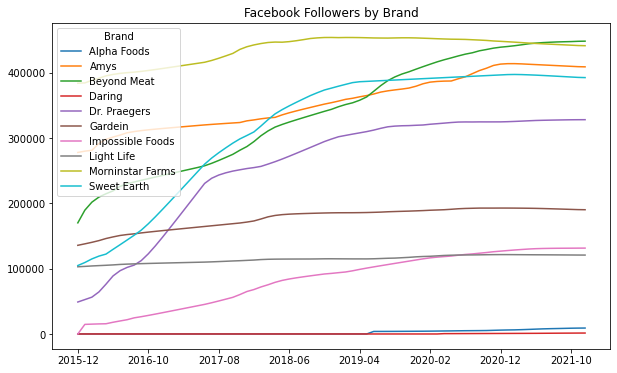

In [139]:
fb_pivot.plot(figsize=(10,6),xlabel="", title= "Facebook Followers by Brand")

<AxesSubplot:title={'center':'Facebook Followers by Brand, Normalized'}>

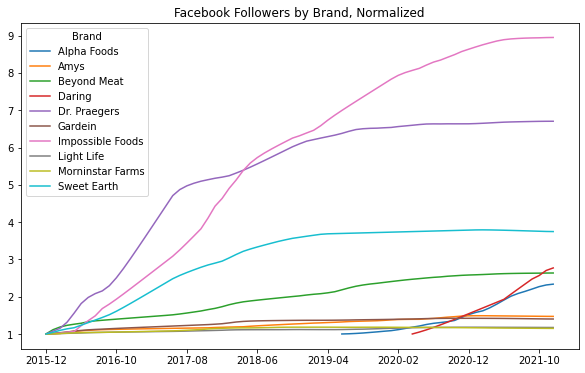

In [140]:
fb_pivot_norm = fb_pivot.copy()

for i in fb_pivot_norm:
    minimum = fb_pivot_norm[fb_pivot_norm[i]>0][i].min()
    
    fb_pivot_norm[i] = fb_pivot_norm[i]/minimum

fb_pivot_norm = fb_pivot_norm.replace(0, np.nan)

fb_pivot_norm.plot(figsize=(10,6),xlabel="", title= "Facebook Followers by Brand, Normalized")

In [120]:
fb_pivot.to_excel("plant_based_meat_fb.xlsx")

In [76]:
#instagram
#instagram__ts_interpolated__2_0
max_date ='2021-12'
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI),
        bigquery.ScalarQueryParameter("max_date", "STRING", max_date)
    ]
)
review_query = """
    SELECT *
    FROM `helio-staging.social.instagram__canonical_brand_account__derived_growth__1_0`
    WHERE canonical_brand_url IN UNNEST (@url)
    AND execution_period = @max_date
    """
query_job = client.query(
    review_query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query
ig = query_job.to_dataframe()
ig["Brand"] = ig["canonical_brand_url"].map(brand_name_di)

In [73]:
ig_pivot = ig.pivot_table(index = "y_m", columns = "Brand", values = "followers_count", fill_value=0)

In [77]:
ig

,canonical_brand_url,growth__3m__followers_count,abs_growth__3m__followers_count,growth__6m__followers_count,abs_growth__6m__followers_count,growth__12m__followers_count,abs_growth__12m__followers_count,growth__3m__following_count,abs_growth__3m__following_count,growth__6m__following_count,...,growth__12m__following_count,abs_growth__12m__following_count,growth__3m__posts_count,abs_growth__3m__posts_count,growth__6m__posts_count,abs_growth__6m__posts_count,growth__12m__posts_count,abs_growth__12m__posts_count,execution_period,Brand
0,gardein.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12,Gardein
1,morningstarfarms.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12,Morninstar Farms
2,daring.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12,Daring
3,impossiblefoods.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12,Impossible Foods
4,beyondmeat.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12,Beyond Meat
5,amys.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12,Amys
6,sweetearthfoods.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12,Sweet Earth
7,drpraegers.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12,Dr. Praegers


In [87]:
#twitter
#twitter__ts_interpolated__2_0
max_date ='2021-12'
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI),
        bigquery.ScalarQueryParameter("max_date", "STRING", max_date)
    ]
)
review_query = """
    SELECT normalized_url, y_m,est_followers_count
    FROM `helio-staging.social.twitter__ts_interpolated__2_0`
    WHERE normalized_url IN UNNEST (@url)
    AND execution_period = @max_date
    """
query_job = client.query(
    review_query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query
tw = query_job.to_dataframe()
tw["Brand"] = tw["normalized_url"].map(brand_name_di)

In [88]:
tw_pivot = tw.pivot_table(index = "y_m", columns = "Brand", values = "est_followers_count", fill_value=0)

<AxesSubplot:xlabel='y_m'>

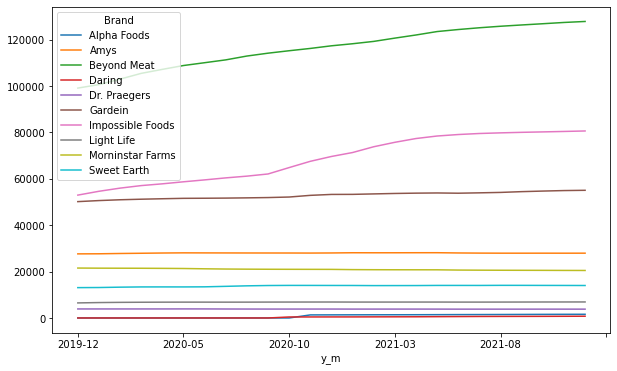

In [128]:
tw_pivot.plot(figsize=(10,6))

<AxesSubplot:title={'center':'Twitter Followers by Brand, Normalized'}>

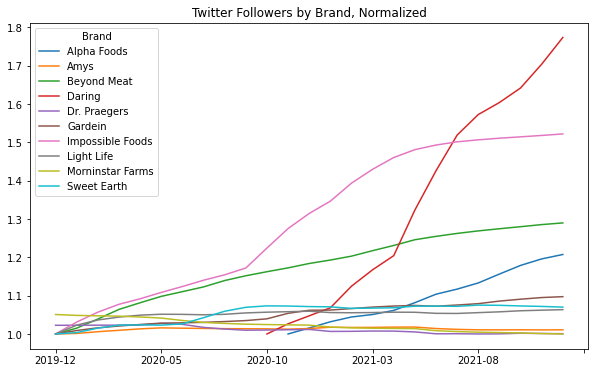

In [141]:
tw_pivot_norm = tw_pivot.copy()

for i in tw_pivot_norm:
    minimum = tw_pivot_norm[tw_pivot_norm[i]>0][i].min()
    
    tw_pivot_norm[i] = tw_pivot_norm[i]/minimum

tw_pivot_norm = tw_pivot_norm.replace(0, np.nan)
tw_pivot_norm.plot(figsize=(10,6),xlabel="", title= "Twitter Followers by Brand, Normalized")

In [121]:
tw_pivot.to_excel("plant_based_meat_tw.xlsx")